# Imports

In [137]:
import pandas as pd
import numpy as np
import math

# models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor, XGBClassifier

# processing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score,cross_validate
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import NearMiss
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

# plot
import matplotlib.pyplot as plt
import seaborn as sns

# config
def make_report(y_pred , y_true):
    print ("")
    print ("Classification Report: ")
    print (classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plot_confusion_matrix(conf_mat=cm)
    plt.show()
    
def reg_report(true, pred, name='Test', is_print = True):
    acc = ((pred<=true*1.1) & (true*0.9<=pred)).mean()
    rmse = mean_squared_error(true, pred, squared=False)
    if is_print:
        print("\n{} Results :\n".format(name))
        print('RMSE :',rmse)
        print('Accuracy with 5% :', acc)
    return rmse, acc

def eval_report(y_train, pred_train,y_test, pred_test,is_print = True):
    train_rmse, train_acc = reg_report(y_train, pred_train,is_print=is_print, name='Train',)
    test_rmse, test_acc = reg_report(y_test, pred_test,is_print=is_print, name='Test')
    return train_rmse, train_acc, test_rmse, test_acc
pd.set_option('display.max_columns', 50)
path = 'datasets/University/'

# Load Data

In [125]:
data = pd.read_csv(path+'Bitcoin Historical Data - Investing.com.csv', thousands=',')
data['Date'] = pd.to_datetime(data.Date)
data['target'] = data['Price'].shift(1)
data = data.dropna()
data['label'] = data['target'] - data['Price']
data['label'] = (data['label'] / abs(data['label'])) + 1
data['label'] = data['label'] /2
data['Vol.'] = pd.to_numeric(data['Vol.'].apply(lambda x: x[:-1]))
data['Change %'] = pd.to_numeric(data['Change %'].apply(lambda x: x[:-1]))
data = data.fillna(0)
train = data[data.Date < '2020-01-02' ]
test = data[data.Date >= '2020-01-02' ]
feat = ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
print(train.shape)
print(test.shape)

(3455, 9)
(485, 9)


In [101]:
models = {
    'LinearRegression':LinearRegression(),
    'Ridge':Ridge(),
    'Lasso':Lasso(),
    'BayesianRidge()':BayesianRidge(),
    'MLPRegressor':MLPRegressor(),
    'RandomForestRegressor':RandomForestRegressor(),
    'AdaBoostRegressor':AdaBoostRegressor(),
    'GradientBoostingRegressor':GradientBoostingRegressor(),
    'DecisionTreeRegressor':DecisionTreeRegressor(),
    'CatBoostRegressor':CatBoostRegressor(verbose=0)
}

result = pd.DataFrame(columns = ['Model', "Train RMSE", "Test RMSE", "Train Accuracy", "Test Accuracy"])
for name, model in models.items():
    model.fit(train[feat], train['target'])
    train_pred = model.predict(train[feat])
    pred = model.predict(test[feat])
    train_rmse, train_acc, test_rmse, test_acc = eval_report(y_train = train['target'], 
                                                             pred_train = train_pred, 
                                                             y_test = test['target'],
                                                             pred_test = pred,
                                                            is_print = False)
    result = result.append({'Model': name, "Train RMSE":train_rmse, "Test RMSE":test_rmse, "Train Accuracy":train_acc, "Test Accuracy":test_acc}, ignore_index = True)

display(result.sort_values('Test Accuracy'))
result.to_csv(path+'result-10model.csv', index = False)

E:\ProgramData\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69685719.65019138, tolerance: 4108734.2002128786
  positive)


,Model,Train RMSE,Test RMSE,Train Accuracy,Test Accuracy
8,DecisionTreeRegressor,0.015530,15494.760691,1.000000,0.651546
9,CatBoostRegressor,93.687592,16436.542301,0.673227,0.674227
6,AdaBoostRegressor,309.761436,15885.348732,0.309407,0.686598
5,RandomForestRegressor,89.028112,15665.662052,0.984660,0.694845
7,GradientBoostingRegressor,128.167008,15692.101834,0.692041,0.698969
0,LinearRegression,204.181024,1096.602733,0.679595,0.979381
1,Ridge,204.181024,1096.602733,0.679595,0.979381
2,Lasso,204.181789,1096.353084,0.680174,0.979381
3,BayesianRidge(),204.183926,1096.563582,0.679884,0.979381
4,MLPRegressor,206.657296,1120.954733,0.813314,0.979381


## voting

In [105]:
model = VotingRegressor([('Lasso', Lasso()),
                         ('BayesianRidge', BayesianRidge()),
                         ('MLPRegressor', MLPRegressor())])
model.fit(train[feat], train['target'])
train_pred = model.predict(train[feat])
pred = model.predict(test[feat])
train_rmse, train_acc, test_rmse, test_acc = eval_report(y_train = train['target'], 
                                                             pred_train = train_pred, 
                                                             y_test = test['target'],
                                                             pred_test = pred,
                                                            is_print = True)

E:\ProgramData\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69685719.65019138, tolerance: 4108734.2002128786
  positive)



Train Results :

RMSE : 205.96305347824543
Accuracy with 5% : 0.685383502170767

Test Results :

RMSE : 1132.6780972525842
Accuracy with 5% : 0.9752577319587629


## bagging

In [111]:
model1 = Lasso()                  
model2 = BayesianRidge()                
model3 = MLPRegressor()

model1.fit(train[feat], train['target'])
train_pred1 = model1.predict(train[feat])
pred1 = model1.predict(test[feat])

model2.fit(train[feat], train['target'])
train_pred2 = model2.predict(train[feat])
pred2 = model2.predict(test[feat])

model3.fit(train[feat], train['target'])
train_pred3 = model3.predict(train[feat])
pred3 = model3.predict(test[feat])

pred = (pred1+pred2+pred3)/3
train_pred = (train_pred1+train_pred2+train_pred3)/3
train_rmse, train_acc, test_rmse, test_acc = eval_report(y_train = train['target'], 
                                                             pred_train = train_pred, 
                                                             y_test = test['target'],
                                                             pred_test = pred,
                                                            is_print = True)

E:\ProgramData\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69685719.65019138, tolerance: 4108734.2002128786
  positive)



Train Results :

RMSE : 205.0645017748052
Accuracy with 5% : 0.6850940665701881

Test Results :

RMSE : 1086.3938782976395
Accuracy with 5% : 0.9835051546391752


## boosting

In [114]:
boost_train_x = train[feat].copy()
boost_test_x = test[feat].copy()
boost_train_y = train['target'].copy()
boost_test_y = test['target'].copy()


model1 = Lasso()                  
model2 = BayesianRidge()                
model3 = MLPRegressor()

model1.fit(boost_train_x, boost_train_y)
boost_train_x['pred1'] = model1.predict(boost_train_x)
boost_test_x['pred1'] = model1.predict(boost_test_x)

model2.fit(boost_train_x, boost_train_y)
boost_train_x['pred2'] = model2.predict(boost_train_x)
boost_test_x['pred2'] = model2.predict(boost_test_x)

model3.fit(boost_train_x, boost_train_y)
train_pred = model3.predict(boost_train_x)
pred = model3.predict(boost_test_x)

pred = (pred1+pred2+pred3)/3
train_pred = (train_pred1+train_pred2+train_pred3)/3
train_rmse, train_acc, test_rmse, test_acc = eval_report(y_train = train['target'], 
                                                             pred_train = train_pred, 
                                                             y_test = test['target'],
                                                             pred_test = pred,
                                                            is_print = True)

E:\ProgramData\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69685719.65019138, tolerance: 4108734.2002128786
  positive)



Train Results :

RMSE : 204.99367317582505
Accuracy with 5% : 0.6879884225759768

Test Results :

RMSE : 1102.0326468190078
Accuracy with 5% : 0.9814432989690721


In [117]:
result = pd.DataFrame(columns = ['loss', 'learning_rate', 'n_estimators', "Train RMSE", "Test RMSE", "Train Accuracy", "Test Accuracy"])

for loss in ['linear', 'square', 'exponential']:
    for n_estimators in [50,100,150]:
        for learning_rate in [0.2, 0.5, 0.9]:
            model = AdaBoostRegressor(loss=loss, n_estimators=n_estimators, learning_rate=learning_rate)
            model.fit(train[feat], train['target'])
            train_pred = model.predict(train[feat])
            pred = model.predict(test[feat])
            train_rmse, train_acc, test_rmse, test_acc = eval_report(y_train = train['target'], 
                                                                     pred_train = train_pred, 
                                                                     y_test = test['target'],
                                                                     pred_test = pred,
                                                                    is_print = False)
            result = result.append({'loss': loss, 'learning_rate':learning_rate, 'n_estimators':n_estimators, "Train RMSE":train_rmse, "Test RMSE":test_rmse, "Train Accuracy":train_acc, "Test Accuracy":test_acc}, ignore_index = True)

display(result.sort_values('Test Accuracy'))
result.sort_values('Test Accuracy').to_csv(path+'result-ada.csv', index = False)     

,loss,learning_rate,n_estimators,Train RMSE,Test RMSE,Train Accuracy,Test Accuracy
0,linear,0.2,50,277.002331,16241.628269,0.318090,0.684536
4,linear,0.5,100,291.516007,15845.107007,0.294356,0.684536
11,square,0.9,50,310.031233,15579.580213,0.427786,0.684536
10,square,0.5,50,297.300346,15595.778555,0.374240,0.686598
2,linear,0.9,50,290.551777,16011.126391,0.389291,0.688660
8,linear,0.9,150,313.094121,15844.606365,0.375109,0.688660
9,square,0.2,50,291.018006,15791.047779,0.304776,0.688660
18,exponential,0.2,50,276.288132,16087.273380,0.327062,0.690722
15,square,0.2,150,308.350599,15714.439825,0.360926,0.690722
22,exponential,0.5,100,313.539755,16008.140817,0.382923,0.692784


In [118]:
result = pd.DataFrame(columns = ['max_depth', 'criterion', 'n_estimators', "Train RMSE", "Test RMSE", "Train Accuracy", "Test Accuracy"])

for max_depth in [50, 100, 150]:
    for n_estimators in [50,100,150]:
        for criterion in ['mse', 'mae']:
            model = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, criterion=criterion)
            model.fit(train[feat], train['target'])
            train_pred = model.predict(train[feat])
            pred = model.predict(test[feat])
            train_rmse, train_acc, test_rmse, test_acc = eval_report(y_train = train['target'], 
                                                                     pred_train = train_pred, 
                                                                     y_test = test['target'],
                                                                     pred_test = pred,
                                                                    is_print = False)
            result = result.append({'max_depth': max_depth, 'criterion':criterion, 'n_estimators':n_estimators, "Train RMSE":train_rmse, "Test RMSE":test_rmse, "Train Accuracy":train_acc, "Test Accuracy":test_acc}, ignore_index = True)

display(result.sort_values('Test Accuracy'))
result.sort_values('Test Accuracy').to_csv(path+'result-random.csv', index = False)     

,max_depth,criterion,n_estimators,Train RMSE,Test RMSE,Train Accuracy,Test Accuracy
13,150,mae,50,91.829922,15717.490399,0.984370,0.688660
0,50,mse,50,92.089832,15668.668184,0.985239,0.690722
1,50,mae,50,92.244219,15650.851061,0.984370,0.690722
2,50,mse,100,90.514323,15712.349922,0.985528,0.690722
3,50,mae,100,89.615872,15663.444532,0.984370,0.690722
7,100,mae,50,88.725115,15632.733846,0.986397,0.690722
16,150,mse,150,89.816676,15720.995503,0.984949,0.690722
15,150,mae,100,88.838169,15712.939684,0.984949,0.692784
14,150,mse,100,92.855080,15607.556793,0.984660,0.692784
12,150,mse,50,91.422335,15647.134086,0.985239,0.692784


# classification


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.43      0.62      0.51       215
         1.0       0.53      0.34      0.41       270

    accuracy                           0.46       485
   macro avg       0.48      0.48      0.46       485
weighted avg       0.48      0.46      0.45       485



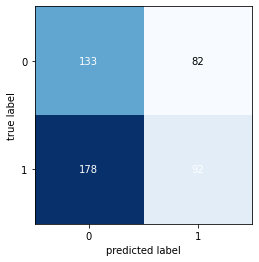

In [133]:
clf = RandomForestClassifier()
clf.fit(train[feat], train['label'])
pred = clf.predict(test[feat])
make_report(pred, test['label'])


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.45      0.68      0.54       215
         1.0       0.58      0.35      0.43       270

    accuracy                           0.49       485
   macro avg       0.52      0.51      0.49       485
weighted avg       0.52      0.49      0.48       485



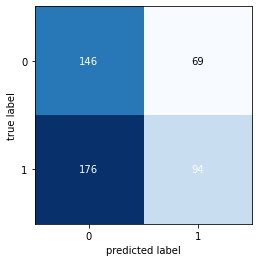

In [136]:
clf = CatBoostClassifier(verbose=0)
clf.fit(train[feat], train['label'])
pred = clf.predict(test[feat])
make_report(pred, test['label'])

# XGBOOST


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.46      0.67      0.54       215
         1.0       0.58      0.36      0.44       270

    accuracy                           0.50       485
   macro avg       0.52      0.52      0.49       485
weighted avg       0.53      0.50      0.49       485



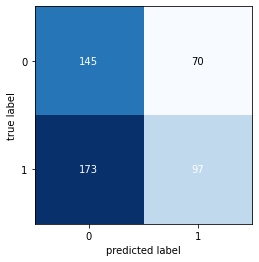

In [138]:
clf = XGBClassifier(verbose=0)
clf.fit(train[feat], train['label'])
pred = clf.predict(test[feat])
make_report(pred, test['label'])

In [139]:
model = XGBRegressor()
model.fit(train[feat], train['target'])
train_pred = model.predict(train[feat])
pred = model.predict(test[feat])
train_rmse, train_acc, test_rmse, test_acc = eval_report(y_train = train['target'], 
                                                         pred_train = train_pred, 
                                                         y_test = test['target'],
                                                         pred_test = pred,
                                                        is_print = True)


Train Results :

RMSE : 31.322374853637452
Accuracy with 5% : 0.8057887120115774

Test Results :

RMSE : 15692.485235521754
Accuracy with 5% : 0.6927835051546392
